# Pipeline for High-z Radio Galaxies 13: Study behaviour of scores on radio flux

## Introduction

In this file, three models will be applied consecutively in order to predict  
the detection of Radio Galaxies (radio AGN) and their redshift.  

In principle, this pipeline should be applied to data in Stripe 82. But  
it can be used with any other suitable dataset.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay
import sklearn.pipeline
import colorcet as cc
# from pycaret import classification as pyc
# from pycaret import regression as pyr
from joblib import dump, load
import pandas as pd
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

In [3]:
plt.rcParams['text.usetex'] = True

---

## Reading data

Flags.

In [4]:
save_plot_flag      = False
save_preds_flag     = False

In [5]:
used_area           = 'HETDEX'  # can be 'S82', 'HETDEX', 'COSMOS'

In [6]:
file_name_dict      = {'S82': gv.file_S82, 'HETDEX': gv.file_HETDEX, 'COSMOS': gv.file_COSMOS}
file_name           = file_name_dict[used_area]

In [7]:
feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'W1mag', 'W2mag', 'num_imputed']
feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'W1mag', 'W2mag', 'num_imputed']
feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'W1mag', 'W2mag', 'num_imputed']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [8]:
# full_catalog_df     = pd.read_hdf(gv.cat_path + file_name, key='df').drop(columns=features_2_discard)

In [9]:
full_catalog_df = pd.read_hdf(gv.preds_path + 'HETDEX_full_prediction.h5', key='df')

In [10]:
full_catalog_df.loc[(full_catalog_df.loc[:, 'Sint_LOFAR_non_imp'] == 0), 'Sint_LOFAR_non_imp'] = np.nan

In [11]:
full_catalog_df['SNR_LOFAR'] = full_catalog_df.loc[:, 'Sint_LOFAR_non_imp'] / full_catalog_df.loc[:, 'rms_LOFAR']

In [12]:
if used_area == 'S82':
    full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'VLAS82_detect'].copy()
    full_catalog_df = full_catalog_df.drop(columns=['VLAS82_detect'])
if used_area == 'COSMOS':
    full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'COSMOSVLA3_detect'].copy()
    full_catalog_df = full_catalog_df.drop(columns=['COSMOSVLA3_detect'])

Create features with class and combined redshift.

In [13]:
# full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
filter_non_confirmed                = np.array(full_catalog_df.loc[:, 'class'] == 1) | np.array(full_catalog_df.loc[:, 'class'] == 0)
# full_catalog_df.loc[~filter_non_confirmed, 'class'] = np.nan
# idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
# full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

In [14]:
known_idx            = np.loadtxt(gv.indices_path + 'indices_known.txt')
train_idx            = np.loadtxt(gv.indices_path + 'indices_train.txt')
train_validation_idx = np.loadtxt(gv.indices_path + 'indices_train_validation.txt')  # in the future, fix naming
validation_idx       = np.loadtxt(gv.indices_path + 'indices_validation.txt')  # in the future, fix naming
calibration_idx      = np.loadtxt(gv.indices_path + 'indices_calibration.txt')
test_idx             = np.loadtxt(gv.indices_path + 'indices_test.txt')
    
train_test_df        = full_catalog_df.loc[train_validation_idx]
train_df             = full_catalog_df.loc[train_idx]
test_df              = full_catalog_df.loc[validation_idx]
calibration_df       = full_catalog_df.loc[calibration_idx]
validation_df        = full_catalog_df.loc[test_idx]
    
print('Shape of used data in HETDEX')
print('-' * 60)
print(f'Full confirmed dataset size:                      {full_catalog_df.shape}')
print(f'Data for Modeling (Train, Test, and Calibration): {train_test_df.shape}')
print(f'Training data:                                    {train_df.shape}')
print(f'Testing data:                                     {test_df.shape}')
print(f'Calibration data:                                 {calibration_df.shape}')
print(f'Validation data:                                  {validation_df.shape}')
print('-' * 60)
print()

Shape of used data in HETDEX
------------------------------------------------------------
Full confirmed dataset size:                      (15136878, 107)
Data for Modeling (Train, Test, and Calibration): (94987, 107)
Training data:                                    (75989, 107)
Testing data:                                     (9499, 107)
Calibration data:                                 (9499, 107)
Validation data:                                  (23747, 107)
------------------------------------------------------------



In [15]:
np.array(train_test_df.columns)

array(['RA_ICRS', 'DE_ICRS', 'Name', 'TYPE', 'Z', 'band_num',
       'Sint_LOFAR', 'Sint_LOFAR_AB', 'Sint_LOFAR_non_imp', 'rms_LOFAR',
       'is_str', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag',
       'ymag', 'W3mag', 'W4mag', 'Jmag', 'Hmag', 'Kmag', 'g_r', 'g_i',
       'g_z', 'g_y', 'g_J', 'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4',
       'r_i', 'r_z', 'r_y', 'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3',
       'r_W4', 'i_z', 'i_y', 'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3',
       'i_W4', 'z_y', 'z_J', 'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4',
       'y_J', 'y_H', 'y_K', 'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K',
       'J_W1', 'J_W2', 'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3',
       'H_W4', 'K_W1', 'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4',
       'W2_W3', 'W2_W4', 'W3_W4', 'radio_detect', 'LOFAR_detect', 'class',
       'radio_AGN', 'Prob_AGN', 'Prob_radio_AGN', 'Prob_radio_gal',
       'pred_Z_rAGN', 'pred_Z_rGal', 'pred_class_cal',
       'p

In [43]:
filter_pred_AGN_train_test = np.array(train_test_df.loc[:, 'pred_class_cal'] == 1)

In [50]:
cm_AGN_gal_train_test = gf.conf_mat_func(train_test_df.loc[:, 'class'], train_test_df.loc[:, 'pred_class_cal'])
cm_radio_train_test   = gf.conf_mat_func(train_test_df.loc[filter_pred_AGN_train_test, 'radio_detect'], 
                                         train_test_df.loc[filter_pred_AGN_train_test, 'pred_radio_cal_AGN'])

In [51]:
prec_AGN_gal_train_test = gf.Precision_from_CM(cm_AGN_gal_train_test)
rec_AGN_gal_train_test  = gf.Recall_from_CM(cm_AGN_gal_train_test)

In [52]:
prec_radio_train_test = gf.Precision_from_CM(cm_radio_train_test)
rec_radio_train_test  = gf.Recall_from_CM(cm_radio_train_test)

In [53]:
prec_AGN_gal_train_test

0.96512216

In [54]:
rec_AGN_gal_train_test

0.98763293

In [55]:
prec_radio_train_test

0.45165616

In [56]:
rec_radio_train_test

0.6865882

In [62]:
temp_radio_detect_train_test_flx = train_test_df.loc[filter_pred_AGN_train_test, 'radio_detect'].copy()
LOFAR_flx_range = np.unique(train_test_df.loc[np.isfinite(train_test_df.loc[:, 'Sint_LOFAR_non_imp']) & filter_pred_AGN_train_test, 'Sint_LOFAR_non_imp'])
radio_precs_flx   = []
radio_recalls_flx = []
for count, flx in enumerate(LOFAR_flx_range):
    tmp_filt         = np.array(train_test_df.loc[filter_pred_AGN_train_test, 'Sint_LOFAR_non_imp'] < flx)
    temp_radio_detect_train_test_flx.loc[tmp_filt] = 0
    tmp_radio_cm     = gf.conf_mat_func(temp_radio_detect_train_test_flx, 
                                        train_test_df.loc[filter_pred_AGN_train_test, 'pred_radio_cal_AGN'])
    tmp_radio_prec   = gf.Precision_from_CM(tmp_radio_cm)
    tmp_radio_recall = gf.Recall_from_CM(tmp_radio_cm)
    radio_precs_flx.append(tmp_radio_prec)
    radio_recalls_flx.append(tmp_radio_recall)

In [74]:
temp_radio_detect_train_test_SNR = train_test_df.loc[filter_pred_AGN_train_test, 'radio_detect'].copy()
LOFAR_SNR_range = np.unique(train_test_df.loc[np.isfinite(train_test_df.loc[:, 'SNR_LOFAR']) & filter_pred_AGN_train_test, 'SNR_LOFAR'])
radio_precs_SNR   = []
radio_recalls_SNR = []
for count, SNR in enumerate(LOFAR_SNR_range):
    tmp_filt         = np.array(train_test_df.loc[filter_pred_AGN_train_test, 'SNR_LOFAR'] < SNR)
    temp_radio_detect_train_test_SNR.loc[tmp_filt] = 0
    tmp_radio_cm     = gf.conf_mat_func(temp_radio_detect_train_test_SNR, 
                                        train_test_df.loc[filter_pred_AGN_train_test, 'pred_radio_cal_AGN'])
    tmp_radio_prec   = gf.Precision_from_CM(tmp_radio_cm)
    tmp_radio_recall = gf.Recall_from_CM(tmp_radio_cm)
    radio_precs_SNR.append(tmp_radio_prec)
    radio_recalls_SNR.append(tmp_radio_recall)

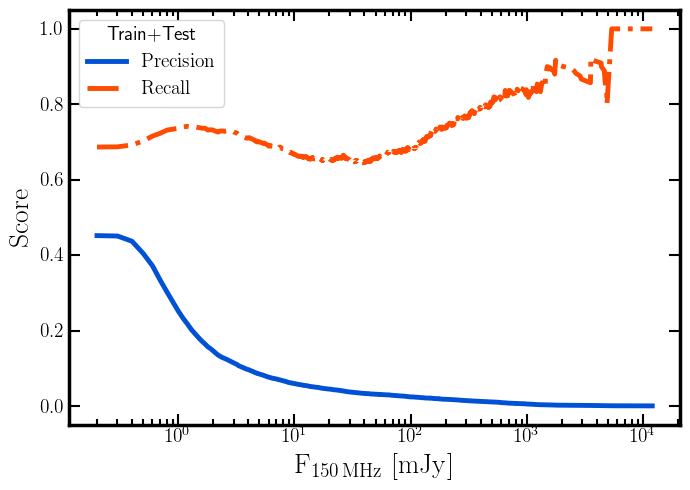

In [109]:
fig             = plt.figure(figsize=(7,5))
ax1             = fig.add_subplot(111)

ax1.plot(LOFAR_flx_range, radio_precs_flx, ls='-', marker='None', label=r'$\mathrm{Precision}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.05))
ax1.plot(LOFAR_flx_range, radio_recalls_flx, ls='-.', marker='None', label=r'$\mathrm{Recall}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.95))
ax1.set_xscale('log')
# ax1.set_yscale('log')
# ax1.set_xlim(right=1.0)
ax1.set_xlabel(r'$\mathrm{F}_{150 \, \mathrm{MHz}} ~ [\mathrm{mJy}]$', fontsize=20)
ax1.set_ylabel(r'$\mathrm{Score}$', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.legend(loc='best', fontsize=14, title='Train+Test', title_fontsize=14)
fig.tight_layout()
plt.show()

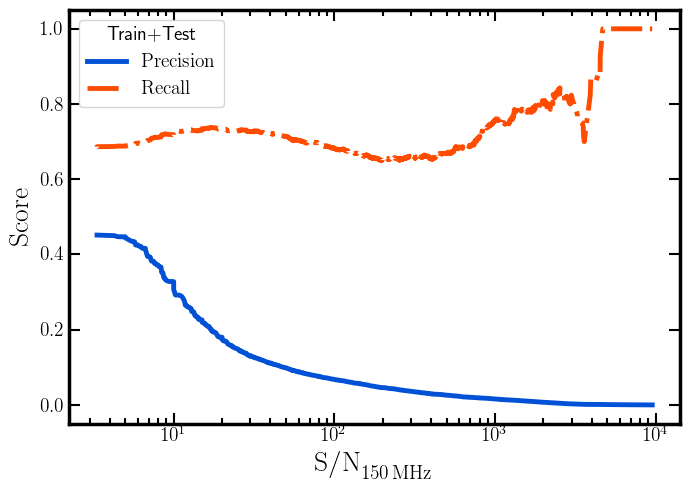

In [101]:
fig             = plt.figure(figsize=(7,5))
ax1             = fig.add_subplot(111)

ax1.plot(LOFAR_SNR_range, radio_precs_SNR, ls='-', marker='None', label=r'$\mathrm{Precision}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.05))
ax1.plot(LOFAR_SNR_range, radio_recalls_SNR, ls='-.', marker='None', label=r'$\mathrm{Recall}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.95))
ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.set_xlabel(r'$\mathrm{S/N}_{150 \, \mathrm{MHz}}$', fontsize=20)
ax1.set_ylabel(r'$\mathrm{Score}$', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.legend(loc='best', fontsize=14, title='Train+Test', title_fontsize=14)
fig.tight_layout()
plt.show()

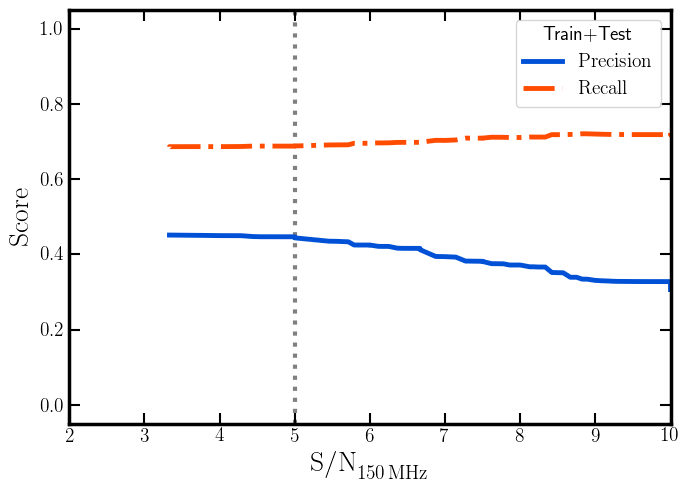

In [107]:
fig             = plt.figure(figsize=(7,5))
ax1             = fig.add_subplot(111)

ax1.plot(LOFAR_SNR_range, radio_precs_SNR, ls='-', marker='None', label=r'$\mathrm{Precision}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.05))
ax1.plot(LOFAR_SNR_range, radio_recalls_SNR, ls='-.', marker='None', label=r'$\mathrm{Recall}$', 
         lw=3.5, color=plt.get_cmap('cet_rainbow')(0.95))
ax1.axvline(x=5.0, ls=':', lw=3.0, color='gray', zorder=1)
# ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.set_xlim(left=2.0, right=10.0)
ax1.set_xlabel(r'$\mathrm{S/N}_{150 \, \mathrm{MHz}}$', fontsize=20)
ax1.set_ylabel(r'$\mathrm{Score}$', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.legend(loc='best', fontsize=14, title='Train+Test', title_fontsize=14)
fig.tight_layout()
plt.show()

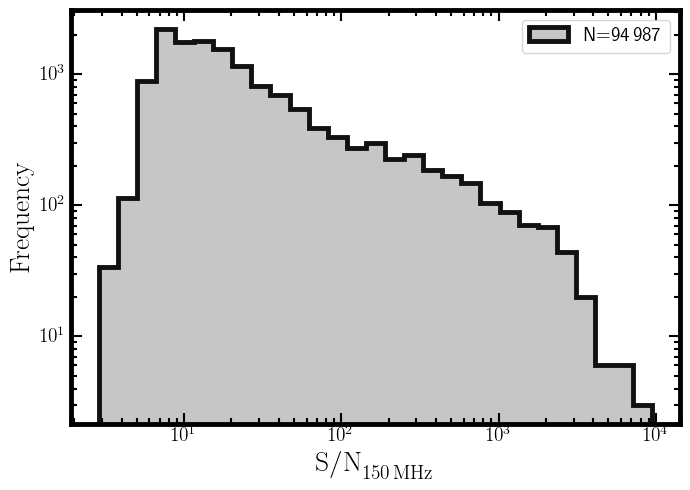

In [112]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='log', yscale='log')

set_to_plot     = train_test_df

min_SNR  = np.nanmin(set_to_plot.loc[:, 'SNR_LOFAR'])
max_SNR  = np.nanmax(set_to_plot.loc[:, 'SNR_LOFAR'])
SNR_bins = np.logspace(np.log10(min_SNR), np.log10(max_SNR), 30)

sample_size = len(set_to_plot.loc[:, 'SNR_LOFAR'])

ax1.hist(set_to_plot.loc[:, 'SNR_LOFAR'], bins=SNR_bins, histtype='stepfilled', 
         ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, 
         label=f'N={sample_size:,}'.replace(',', '$\,$'))
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel(r'$\mathrm{S/N}_{150 \, \mathrm{MHz}}$', size=20)
ax1.set_ylabel(r'$\mathrm{Frequency}$', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
plt.show()

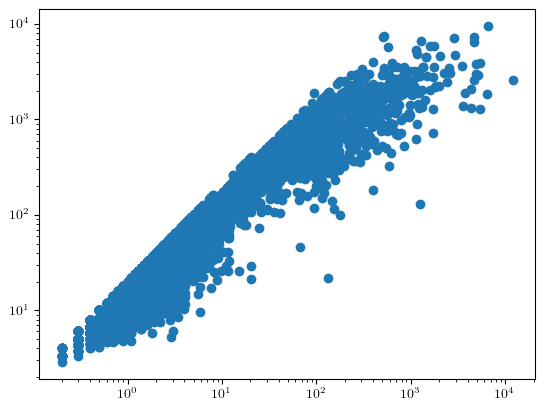

In [36]:
plt.plot(train_test_df.loc[:, 'Sint_LOFAR_non_imp'], train_test_df.loc[:, 'SNR_LOFAR'], ls='None', marker='o')
plt.xscale('log')
plt.yscale('log')

In [16]:
np.sum(np.array(train_test_df.loc[:, 'class'] == 1))

40430

In [17]:
np.sum(np.array(train_test_df.loc[:, 'class'] == 0))

54557

Create column for detection as Radio AGN

In [12]:
# full_catalog_df['radio_AGN']      = (np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) &\
#                                      np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)).astype(int)

Discard minor features.

In [13]:
# full_catalog_df                     = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'zsp'])

#### As we want to predict, only use sources that have not previous spectroscopic classification

In [14]:
print(f'The used data set (in {used_area}) has {len(full_catalog_df):,} sources.')
print(f'And {np.sum(filter_non_confirmed):,} have previous spectroscopic classification.')

The used data set (in HETDEX) has 15,136,878 sources.
And 118,734 have previous spectroscopic classification.


In [15]:
# full_catalog_df                     = full_catalog_df.loc[~filter_non_confirmed]

In [16]:
print(f'This pipeline will predict properties for {len(full_catalog_df):,} sources in {used_area}.')

This pipeline will predict properties for 15,136,878 sources in HETDEX.


In [17]:
np.array(full_catalog_df.columns)

array(['RA_ICRS', 'DE_ICRS', 'Name', 'TYPE', 'Z', 'band_num',
       'Sint_LOFAR', 'Sint_LOFAR_AB', 'Sint_LOFAR_non_imp', 'rms_LOFAR',
       'is_str', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag',
       'ymag', 'W3mag', 'W4mag', 'Jmag', 'Hmag', 'Kmag', 'g_r', 'g_i',
       'g_z', 'g_y', 'g_J', 'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4',
       'r_i', 'r_z', 'r_y', 'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3',
       'r_W4', 'i_z', 'i_y', 'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3',
       'i_W4', 'z_y', 'z_J', 'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4',
       'y_J', 'y_H', 'y_K', 'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K',
       'J_W1', 'J_W2', 'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3',
       'H_W4', 'K_W1', 'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4',
       'W2_W3', 'W2_W4', 'W3_W4', 'radio_detect', 'LOFAR_detect', 'class',
       'radio_AGN', 'Prob_AGN', 'Prob_radio_AGN', 'Prob_radio_gal',
       'pred_Z_rAGN', 'pred_Z_rGal', 'pred_class_cal',
       'p

---

### Load models

In [ ]:
cols_AGN   = ['g_r', 'r_i', 'r_J', 'i_z', 'i_y', 
              'z_y', 'z_W2', 'y_J', 'y_W1', 'y_W2', 'J_H', 'H_K', 
              'H_W3', 'W1_W2', 'W1_W3', 'W3_W4']  # Only colours (no 'band_num', 'W4mag')
cols_radio = ['g_r', 'g_i', 'r_i', 'r_z', 'i_z', 
              'z_y', 'z_W1', 'y_J', 'y_W1', 'J_H', 'H_K', 'K_W3', 
              'K_W4', 'W1_W2', 'W2_W3']  # Only colours (no 'band_num', 'W4mag')
cols_z     = ['g_r', 'g_W3', 'r_i', 'r_z', 'i_z', 
              'i_y', 'z_y', 'y_J', 'y_W1', 'J_H', 'H_K', 'K_W3', 
              'K_W4', 'W1_W2', 'W2_W3']  # Only colours (no 'band_num', 'W4mag')

cols_cols = list(np.unique(cols_AGN + cols_radio + cols_z))